In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

In [20]:
import numpy as np
import pandas as pd
import torch
import torchvision as tv
import re
import time
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Module, GRU, Embedding, Linear, Sigmoid, CrossEntropyLoss, ReLU, Tanh, Sequential
from torch import nn
from torchvision import transforms
import torch.optim as optim
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [21]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [23]:
fmnist = datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
data_loader = DataLoader(fmnist, batch_size=batch_size, shuffle=True)

In [24]:
class Generator(Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = Sequential(
            Linear(self.nz, 256),
            ReLU(),

            Linear(256, 512),
            ReLU(),

            Linear(512, 784),
            Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


In [25]:
class Discriminator(Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = Sequential(
            Linear(self.n_input, 1024),
            ReLU(),
            Linear(1024, 512),
            ReLU(),
            Linear(512, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

Initialize the Neural Networks and Define the Optimizers

In [26]:


generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
######################


In [27]:
# optimizers

optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [28]:
# loss function
criterion = nn.BCELoss()


In [29]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [30]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [31]:
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [32]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [33]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [34]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [35]:
# create the noise vector
noise = create_noise(sample_size, nz)
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [36]:
# path = "/content/drive/MyDrive/Deep_Learning/HW3/"
path = "./models/vanilla_gan/"
epochs = 200
# k = 10
length = 0.

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

for epoch in range(epochs):
    start = time.time()
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in enumerate(data_loader):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            # print(create_noise(b_size, nz).shape)
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, path + f"gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    end = time.time() - start
    length += end
    mean_so_far = length / (epoch+1)
    time_left = (mean_so_far * (epochs - epoch - 1))/60
    
    print(f"Epoch {epoch} of {epochs}:\t\t{end:.2f} seconds;\ttotal: {length:.2f};\tminutes left: {time_left:.2f}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

eft: 103.96
Generator loss: 9.62438107, Discriminator loss: 0.46294844
Epoch 45 of 200:		46.84 seconds;	total: 1857.75;	minutes left: 103.66
Generator loss: 6.38235092, Discriminator loss: 0.21268624
Epoch 46 of 200:		46.14 seconds;	total: 1903.89;	minutes left: 103.30
Generator loss: 6.42292118, Discriminator loss: 0.16593960
Epoch 47 of 200:		43.39 seconds;	total: 1947.28;	minutes left: 102.77
Generator loss: 6.04775047, Discriminator loss: 0.20457686
Epoch 48 of 200:		43.26 seconds;	total: 1990.54;	minutes left: 102.24
Generator loss: 6.78511286, Discriminator loss: 0.23237662
Epoch 49 of 200:		39.95 seconds;	total: 2030.49;	minutes left: 101.52
Generator loss: 8.27967834, Discriminator loss: 0.35382560
Epoch 50 of 200:		41.38 seconds;	total: 2071.87;	minutes left: 100.89
Generator loss: 7.79340029, Discriminator loss: 0.23028862
Epoch 51 of 200:		36.66 seconds;	total: 2108.52;	minutes left: 100.02
Generator loss: 7.11012506, Discriminator loss: 0.15610741
Epoch 52 of 200:		31.86 se

In [37]:
print('DONE TRAINING')
torch.save(generator.state_dict(), path + 'generator.pth')
path

DONE TRAINING


'./models/vanilla_gan/'

In [38]:
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave(path + 'generator_images.gif', imgs)

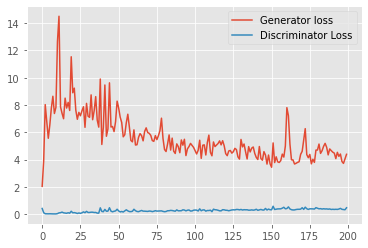

In [40]:
plt.figure()
plt.plot([x.detach() for x in losses_g], label='Generator loss')
plt.plot([x.detach() for x in losses_d], label='Discriminator Loss')
plt.legend()
plt.savefig(path + 'loss.png')